# 방향
- 이중분류 할것이다: 사진이 주어졌을때 이게 개냐 ~ 아니냐 ~

# 할거
- 3개의 함수 : 학습, 검증 및 테스트, 예측
- 모델 : 층, 층별 노드, 퍼셉트론 수 조절한게 있어야 함

# 30 * 30 으로 resize 된 사진으로 모델 돌림

In [140]:
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import torch
import torch.nn.functional as F 
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim 
import torchmetrics.functional as metrics

In [141]:
cat_file = 'resize_cat_df.csv'
dog_file = 'resize_dog_df.csv'
cat_data = pd.read_csv(cat_file)
dog_data = pd.read_csv(dog_file)
data = pd.concat([cat_data, dog_data])

In [142]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 0 to 438
Columns: 901 entries, Unnamed: 0 to 899
dtypes: int64(901)
memory usage: 6.1 MB


In [143]:
cat_data.shape

(452, 901)

In [144]:
dog_data.shape

(439, 901)

In [145]:
data.shape

(891, 901)

In [146]:
col_list = []
for i in range(1, 902):
    col_list.append(f"pixel{i}")
data.columns = col_list
data.columns

Index(['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7',
       'pixel8', 'pixel9', 'pixel10',
       ...
       'pixel892', 'pixel893', 'pixel894', 'pixel895', 'pixel896', 'pixel897',
       'pixel898', 'pixel899', 'pixel900', 'pixel901'],
      dtype='object', length=901)

In [147]:
data.index

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       429, 430, 431, 432, 433, 434, 435, 436, 437, 438],
      dtype='int64', length=891)

In [148]:
type_list = []
for i in range(cat_data.shape[0]):
    type_list.append('cat')
for i in range(dog_data.shape[0]):
    type_list.append('dog')
# type_list

data['type'] = type_list

In [149]:
data.columns

Index(['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7',
       'pixel8', 'pixel9', 'pixel10',
       ...
       'pixel893', 'pixel894', 'pixel895', 'pixel896', 'pixel897', 'pixel898',
       'pixel899', 'pixel900', 'pixel901', 'type'],
      dtype='object', length=902)

In [150]:
data.shape

(891, 902)

# 피처, 타겟 분리 & 정규화

In [151]:
feature = data[data.columns[:-1]]
target = data[data.columns[-1]]

In [152]:
print(f"feature.shape: {feature.shape}, target.shape: {target.shape}")

feature.shape: (891, 901), target.shape: (891,)


In [153]:
# cat을 0으로 dog를 1로 변경
target.replace('cat',0, inplace = True)
target.replace('dog',1, inplace = True)
scaled_target = target

In [154]:
# 피처를 정규화 시킴
scaled_feature = feature/256.

In [155]:
scaled_feature.shape

(891, 901)

# 학습 데이터셋 준비 (학습용, 검증용, 테스트용)

In [156]:
# 사용자 정의 데이터셋 및 전체 데이터셋 준비

class all_dataset(Dataset):
    def __init__(self, feature_data, target_data):
        super().__init__()  # 어미를 상속받았다
        # 해당 클래스의 인스턴스 초기화함
        self.data = torch.FloatTensor(feature_data)
        self.target = torch.FloatTensor(target_data)
        
    def __len__(self):
        return self.target.shape[0]
    
    def __getitem__(self, index):
        return self.data[index], self.target[index]

In [157]:
# 전체 DataSet 생성
feature_np = np.array(scaled_feature)
target_np = np.array(scaled_target)

animal_dataset = all_dataset(feature_np, target_np)

print(f"feature.shape: {animal_dataset.data.shape}, target.shape: {animal_dataset.target.shape}")

feature.shape: torch.Size([891, 901]), target.shape: torch.Size([891])


In [158]:
# 학습용, 검증용, 테스트용 데이터셋 분리

In [159]:
seed_generator = torch.Generator().manual_seed(11)

train_size, valid_size, test_size = 0.7, 0.1, 0.2

train_dataset, valid_dataset, test_dataset = random_split(animal_dataset, [train_size, valid_size, test_size], generator = seed_generator)

In [160]:
print(f"train dataset length : {len(train_dataset)}")
print(f"valid dataset length : {len(valid_dataset)}")
print(f"test dataset length : {len(test_dataset)}")

train dataset length : 624
valid dataset length : 89
test dataset length : 178


# 데이터 로더 생성

In [161]:
batch = 20

train_loader = DataLoader(train_dataset, batch_size = batch)
val_loader = DataLoader(valid_dataset, batch_size = batch)
test_loader = DataLoader(test_dataset, batch_size = batch)

print(train_loader, val_loader, test_loader, sep='\n\n')

# 모델 준비

In [162]:
# 전방향 학습용 모델 클래스를 생성해보자
# 이중 분류  | 입력 피처 수 : 512 * 512  |  출력 피처 수 : 1 (0 or 1)

class myModel(nn.Module):
    def __init__(self, input_num, output_num):
        super().__init__()
        self.layer1 = nn.Linear(input_num, 800)  # 입력층
        self.layer2 = nn.Linear(800, 400) # 은닉층
        self.layer3 = nn.Linear(400, 300) # 은닉층
        self.layer4 = nn.Linear(300, 150) # 은닉층
        self.layer5 = nn.Linear(150, 50) # 은닉층
        self.layer6 = nn.Linear(50, output_num) # 출력층
        self.sig = nn.Sigmoid() # 활성함수 (이진분류니까 sigmoid 선택함)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.sig(x)
        x = self.layer2(x)
        x = self.sig(x)
        x = self.layer3(x)
        x = self.sig(x)
        x = self.layer4(x)
        x = self.sig(x)
        x = self.layer5(x)
        x = self.sig(x)
        x = self.layer6(x)
        x = self.sig(x)

        return x

# 함수 정의 : training, testing, predicting

In [163]:
# 디바이스 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# 학습 모델 인스턴스 생성
dogmodel = myModel(feature_np.shape[1], 1).to(device)

# 손실함수
loss_fn = nn.BCELoss().to(device)
# https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss
# Creates a criterion that measures the Binary Cross Entropy between the target and the input probabilities:


# 분류 갯수
class_num = 1

In [164]:
# 최적화 인스턴스 생성
optimizer = optim.SGD(dogmodel.parameters())

### Q. 왜 이 optimizer를 썻는가?

In [165]:
# 학습용 함수

def training():
    dogmodel.train()
    
    loss_list = []
    evaluation = {'accuracy_list':[], 'recall_list':[], 'precision_list':[], 'f1_score_list':[]}
    for (f, t) in train_loader:
        feature, target = f.to(device), t.to(device)
        
        # 학습
        train_predict = dogmodel(feature)
        target_reshaped = target.unsqueeze(dim=1)
        # print(train_predict.shape, target_reshaped.shape)

        # 손실 계산
        loss = nn.functional.binary_cross_entropy(train_predict, target_reshaped).to(device)
        loss_list.append(loss.item())
        
        # 성능 평가
        accuracy = metrics.accuracy(train_predict, target_reshaped, task = 'binary', num_classes = class_num)
        recall = metrics.recall(train_predict, target_reshaped, task = 'binary', num_classes = class_num)
        precision = metrics.precision(train_predict, target_reshaped, task = 'binary', num_classes = class_num)
        f1_score = metrics.f1_score(train_predict, target_reshaped, task = 'binary', num_classes = class_num)
        evaluation['accuracy_list'].append(accuracy.item())
        evaluation['recall_list'].append(recall.item())
        evaluation['precision_list'].append(precision.item())
        evaluation['f1_score_list'].append(f1_score.item())
        
        # 최적화 (역방향 학습 + 업데이트)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print('   .  .  .')
    
    print('학 습 중')    
    loss_total = (sum(loss_list) / len(loss_list))
    accuracy_total= (sum(evaluation['accuracy_list']) / len(evaluation['accuracy_list']))
    recall_total = (sum(evaluation['recall_list'])/len(evaluation['recall_list']))
    precision_total = (sum(evaluation['precision_list'])/len(evaluation['precision_list']))
    f1_score_total = (sum(evaluation['f1_score_list'])/len(evaluation['f1_score_list']))
    # print('[ TRAINING - Total ]')
    # print(f"loss : {loss_total} \naccuracy : {accuracy_total} \nrecall : {recall_total} \nprecision : {precision_total} \nf1_score : {f1_score_total}")
    return loss_list, evaluation, loss_total, accuracy_total, recall_total, precision_total, f1_score_total

# training()

### Q 함수 training()에서 for문 안에 저 to device는 왜하는거?

In [166]:
# 검증용 함수

def testing():
    dogmodel.eval()
    loss_list = []
    evaluation = {'accuracy_list':[], 'recall_list':[], 'precision_list':[], 'f1_score_list':[]}
    for (f, t) in val_loader:
        feature, target = f.to(device), t.to(device)
        # 학습
        train_predict = dogmodel(feature)
        target_reshaped = target.unsqueeze(dim=1)
        target = target_reshaped
        # 손실 계산
        loss = loss_fn(train_predict, target)
        loss_list.append(loss.item())
        # 성능 평가
        accuracy = metrics.accuracy(train_predict, target, task = 'binary', num_classes = class_num)
        recall = metrics.recall(train_predict, target, task = 'binary', num_classes = class_num)
        precision = metrics.precision(train_predict, target, task = 'binary', num_classes = class_num)
        f1_score = metrics.f1_score(train_predict, target, task = 'binary', num_classes = class_num)
        evaluation['accuracy_list'].append(accuracy.item())
        evaluation['recall_list'].append(recall.item())
        evaluation['precision_list'].append(precision.item())
        evaluation['f1_score_list'].append(f1_score.item())
    print('검증 ing')    
    loss_total = (sum(loss_list) / len(loss_list))
    accuracy_total= (sum(evaluation['accuracy_list']) / len(evaluation['accuracy_list']))
    recall_total = (sum(evaluation['recall_list'])/len(evaluation['recall_list']))
    precision_total = (sum(evaluation['precision_list'])/len(evaluation['precision_list']))
    f1_score_total = (sum(evaluation['f1_score_list'])/len(evaluation['f1_score_list']))    
    return loss_list, evaluation, loss_total, accuracy_total, recall_total, precision_total, f1_score_total

# testing()

# 학습 진행 & 학습 결과 저장 & 학습 에포크별 모델 저장

In [167]:
# 학습 횟수
epoch = 35

train_loss_epoch = []
valid_loss_epoch = []
train_evaluation = []
valid_evaluation = []

for epo in range(epoch):
    # 학습
    tr_loss_list, tr_evaluation, tr_loss_total, tr_accuracy_total, tr_recall_total, tr_precision_total, tr_f1_score_total = training()
    print(f"epo => {epo}")
    train_loss_epoch.append(tr_loss_total)
    train_evaluation.append(tr_evaluation)
    # 검증
    v_loss_list, v_evaluation, v_loss_total, v_accuracy_total, v_recall_total, v_precision_total, v_f1_score_total = testing()
    valid_loss_epoch.append(v_loss_total)
    valid_evaluation.append(v_evaluation)
    print()    

학 습 중
epo => 0
검증 ing

학 습 중
epo => 1
검증 ing
학 습 중
epo => 2
검증 ing

학 습 중
epo => 3
검증 ing
학 습 중
epo => 4
검증 ing

학 습 중
epo => 5
검증 ing
학 습 중
epo => 6
검증 ing

학 습 중
epo => 7
검증 ing

학 습 중
epo => 8
검증 ing
학 습 중
epo => 9
검증 ing

학 습 중
epo => 10
검증 ing
학 습 중
epo => 11
검증 ing

학 습 중
epo => 12
검증 ing
학 습 중
epo => 13
검증 ing

학 습 중
epo => 14
검증 ing
학 습 중
epo => 15
검증 ing

학 습 중
epo => 16
검증 ing
학 습 중
epo => 17
검증 ing

학 습 중
epo => 18
검증 ing

학 습 중
epo => 19
검증 ing
학 습 중
epo => 20
검증 ing

학 습 중
epo => 21
검증 ing
학 습 중
epo => 22
검증 ing

학 습 중
epo => 23
검증 ing

학 습 중
epo => 24
검증 ing
학 습 중
epo => 25
검증 ing

학 습 중
epo => 26
검증 ing
학 습 중
epo => 27
검증 ing

학 습 중
epo => 28
검증 ing
학 습 중
epo => 29
검증 ing

학 습 중
epo => 30
검증 ing
학 습 중
epo => 31
검증 ing

학 습 중
epo => 32
검증 ing
학 습 중
epo => 33
검증 ing

학 습 중
epo => 34
검증 ing


In [168]:
print('전체 에포크 학습 후 loss값들의 평균 : ', sum(train_loss_epoch)/len(train_loss_epoch))
print('검증 후 loss값들의 평균 : ', sum(valid_loss_epoch)/len(valid_loss_epoch))

전체 에포크 학습 후 loss값들의 평균 :  0.6940181642770767
검증 후 loss값들의 평균 :  0.6972441761834282


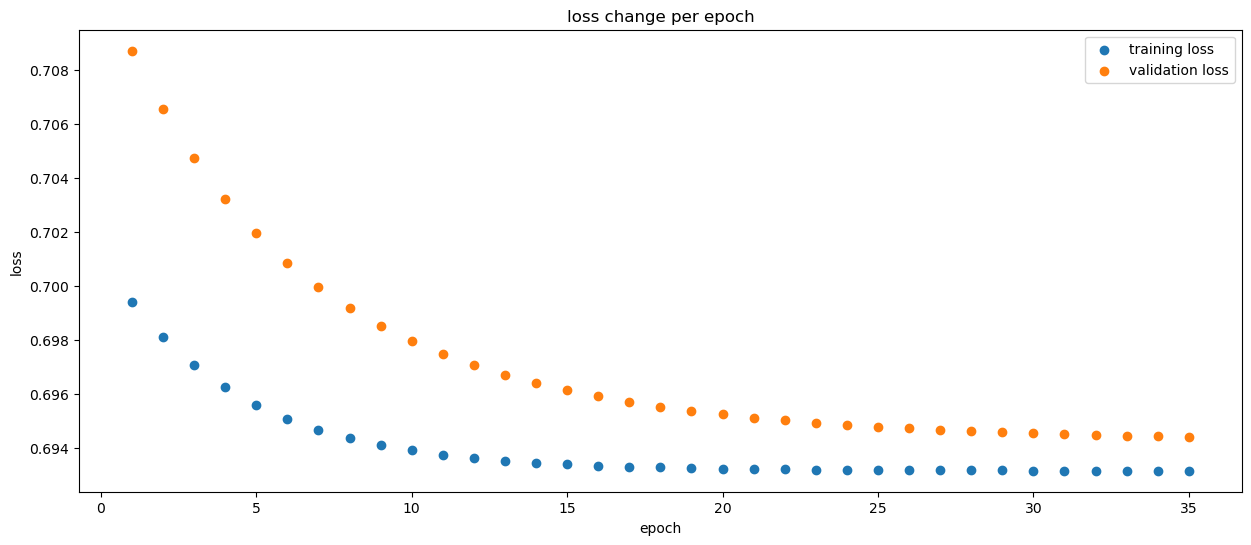

In [169]:
epo_list = []
for i in range(epoch):
    epo_list.append(i+1)
    
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
plt.scatter(epo_list, train_loss_epoch, label='training loss')
plt.scatter(epo_list, valid_loss_epoch, label='validation loss')
plt.legend()
plt.title('loss change per epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# 검증 vs 학습 결과

In [170]:
print(len(train_evaluation))

35


In [171]:
train_evaluation[0].keys()

dict_keys(['accuracy_list', 'recall_list', 'precision_list', 'f1_score_list'])

In [172]:
train_evaluation[0]['accuracy_list']

[0.6499999761581421,
 0.6000000238418579,
 0.6000000238418579,
 0.30000001192092896,
 0.44999998807907104,
 0.44999998807907104,
 0.6000000238418579,
 0.30000001192092896,
 0.3499999940395355,
 0.44999998807907104,
 0.550000011920929,
 0.6499999761581421,
 0.30000001192092896,
 0.44999998807907104,
 0.3499999940395355,
 0.6499999761581421,
 0.550000011920929,
 0.550000011920929,
 0.5,
 0.550000011920929,
 0.4000000059604645,
 0.44999998807907104,
 0.5,
 0.6499999761581421,
 0.5,
 0.6000000238418579,
 0.550000011920929,
 0.3499999940395355,
 0.550000011920929,
 0.6499999761581421,
 0.6499999761581421,
 0.5]

In [173]:
avg_accuracy_per_epoch = sum(train_evaluation[0]['accuracy_list'])/len(train_evaluation[0]['accuracy_list'])
avg_recall_per_epoch = sum(train_evaluation[0]['recall_list'])/len(train_evaluation[0]['recall_list'])
avg_precision_per_epoch = sum(train_evaluation[0]['precision_list'])/len(train_evaluation[0]['precision_list'])
avg_f1_score_per_epoch = sum(train_evaluation[0]['f1_score_list'])/len(train_evaluation[0]['f1_score_list'])

In [174]:
tr_list_accuracy_per_epoch = []
tr_list_recall_per_epoch = []
tr_list_precision_per_epoch = []
tr_list_f1_score_per_epoch = []

for k in range(len(train_evaluation)):
    avg_accuracy_per_epoch = sum(train_evaluation[k]['accuracy_list'])/len(train_evaluation[k]['accuracy_list'])
    avg_recall_per_epoch = sum(train_evaluation[k]['recall_list'])/len(train_evaluation[k]['recall_list'])
    avg_precision_per_epoch = sum(train_evaluation[k]['precision_list'])/len(train_evaluation[k]['precision_list'])
    avg_f1_score_per_epoch = sum(train_evaluation[k]['f1_score_list'])/len(train_evaluation[k]['f1_score_list'])
    
    tr_list_accuracy_per_epoch.append(avg_accuracy_per_epoch)
    tr_list_recall_per_epoch.append(avg_recall_per_epoch)
    tr_list_precision_per_epoch.append(avg_precision_per_epoch)
    tr_list_f1_score_per_epoch.append(avg_f1_score_per_epoch)
    
print('전체 에포크 수에서 학습 후 값들에 대한 평균값')
print('accuracy : ',sum(tr_list_accuracy_per_epoch)/len(tr_list_accuracy_per_epoch))
print('recall : ', sum(tr_list_recall_per_epoch)/len(tr_list_recall_per_epoch))
print('precision : ',sum(tr_list_precision_per_epoch)/len(tr_list_precision_per_epoch))
print('f1 score : ',sum(tr_list_f1_score_per_epoch)/len(tr_list_f1_score_per_epoch))

전체 에포크 수에서 학습 후 값들에 대한 평균값
accuracy :  0.506249999627471
recall :  1.0
precision :  0.506249999627471
f1 score :  0.6645953645929694


In [175]:
v_list_accuracy_per_epoch = []
v_list_recall_per_epoch = []
v_list_precision_per_epoch = []
v_list_f1_score_per_epoch = []

for k in range(len(valid_evaluation)):
    avg_accuracy_per_epoch = sum(valid_evaluation[k]['accuracy_list'])/len(valid_evaluation[k]['accuracy_list'])
    avg_recall_per_epoch = sum(valid_evaluation[k]['recall_list'])/len(valid_evaluation[k]['recall_list'])
    avg_precision_per_epoch = sum(valid_evaluation[k]['precision_list'])/len(valid_evaluation[k]['precision_list'])
    avg_f1_score_per_epoch = sum(valid_evaluation[k]['f1_score_list'])/len(valid_evaluation[k]['f1_score_list'])
    
    v_list_accuracy_per_epoch.append(avg_accuracy_per_epoch)
    v_list_recall_per_epoch.append(avg_recall_per_epoch)
    v_list_precision_per_epoch.append(avg_precision_per_epoch)
    v_list_f1_score_per_epoch.append(avg_f1_score_per_epoch)
    
print('전체 에포크 수에서 검증 값들에 대한 평균값')
print('accuracy : ',sum(v_list_accuracy_per_epoch)/len(v_list_accuracy_per_epoch))
print('recall : ', sum(v_list_recall_per_epoch)/len(v_list_recall_per_epoch))
print('precision : ',sum(v_list_precision_per_epoch)/len(v_list_precision_per_epoch))
print('f1 score : ',sum(v_list_f1_score_per_epoch)/len(v_list_f1_score_per_epoch))

전체 에포크 수에서 검증 값들에 대한 평균값
accuracy :  0.4633333444595335
recall :  1.0
precision :  0.4633333444595335
f1 score :  0.6161786556243894


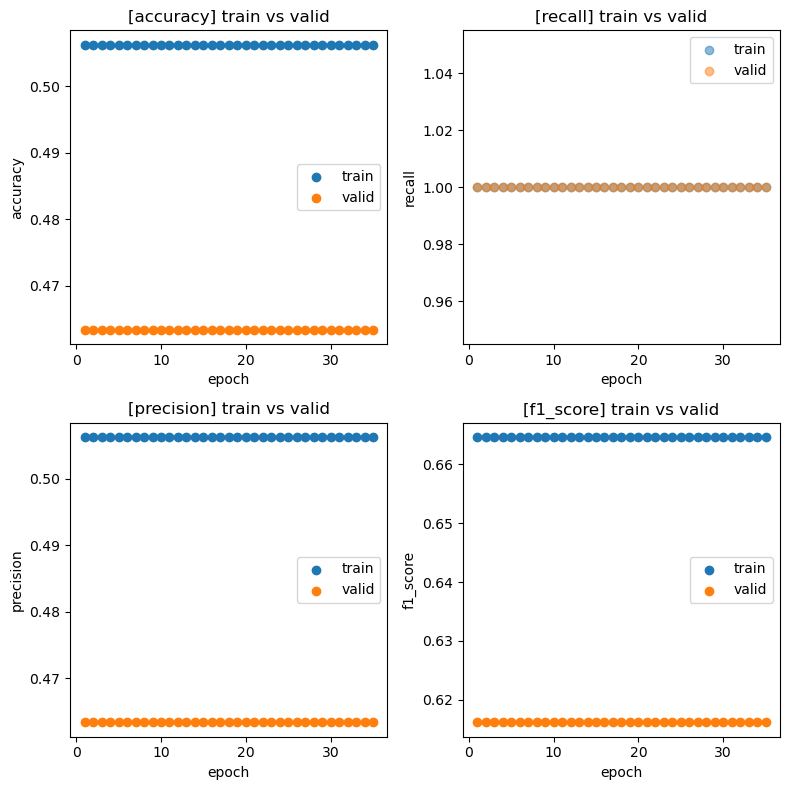

In [176]:
plt.figure(figsize = (8,8))

plt.subplot(2,2,1)
plt.scatter(epo_list, tr_list_accuracy_per_epoch, label = 'train')
plt.scatter(epo_list, v_list_accuracy_per_epoch, label = 'valid')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('[accuracy] train vs valid')
plt.legend()

plt.subplot(2,2,2)
plt.scatter(epo_list, tr_list_recall_per_epoch, label = 'train', alpha = 0.5)
plt.scatter(epo_list, v_list_recall_per_epoch, label = 'valid',  alpha = 0.5)
plt.xlabel('epoch')
plt.ylabel('recall')
plt.title('[recall] train vs valid')
plt.legend()

plt.subplot(2,2,3)
plt.scatter(epo_list, tr_list_precision_per_epoch, label = 'train')
plt.scatter(epo_list, v_list_precision_per_epoch, label = 'valid')
plt.xlabel('epoch')
plt.ylabel('precision')
plt.title('[precision] train vs valid')
plt.legend()

plt.subplot(2,2,4)
plt.scatter(epo_list, tr_list_f1_score_per_epoch, label = 'train')
plt.scatter(epo_list, v_list_f1_score_per_epoch, label = 'valid')
plt.xlabel('epoch')
plt.ylabel('f1_score')
plt.title('[f1_score] train vs valid')
plt.legend()

plt.tight_layout()
plt.show()

### 분석결과
- 각 범위의 차이가 그리 크지 않고 에포크 별로 학습시켜도 딱히 나아지지 않는다.
- 다만 학습과 검증용 사이의 결과 범위 차이가 그리 크지 않으므로 학습한 만큼 검증이 제대로 되었다.
- 즉, 학습 점수는 높지 않지만, 학습 과정에서는 정확히 되었음을 알 수 있다.

# 학습 스케줄러

# 예측

In [177]:
# 예측용 함수
def predicting():
    dogmodel.eval()
    loss_list = []
    evaluation = {'accuracy_list':[], 'recall_list':[], 'precision_list':[], 'f1_score_list':[]}
    for (f, t) in test_loader:
        feature, target = f.to(device), t.to(device)
        # 학습
        train_predict = dogmodel(feature)
        target_reshaped = target.unsqueeze(dim=1)
        target = target_reshaped
        # 손실 계산
        loss = loss_fn(train_predict, target)
        loss_list.append(loss)
        # 성능 평가
        accuracy = metrics.accuracy(train_predict, target, task = 'binary', num_classes = class_num)
        recall = metrics.recall(train_predict, target, task = 'binary', num_classes = class_num)
        precision = metrics.precision(train_predict, target, task = 'binary', num_classes = class_num)
        f1_score = metrics.f1_score(train_predict, target, task = 'binary', num_classes = class_num)
        evaluation['accuracy_list'].append(accuracy.item())
        evaluation['recall_list'].append(recall.item())
        evaluation['precision_list'].append(precision.item())
        evaluation['f1_score_list'].append(f1_score.item())
    loss_total = (sum(loss_list) / len(loss_list))
    accuracy_total= (sum(evaluation['accuracy_list']) / len(evaluation['accuracy_list']))
    recall_total = (sum(evaluation['recall_list'])/len(evaluation['recall_list']))
    precision_total = (sum(evaluation['precision_list'])/len(evaluation['precision_list']))
    f1_score_total = (sum(evaluation['f1_score_list'])/len(evaluation['f1_score_list']))
    return loss_list, evaluation, loss_total, accuracy_total, recall_total, precision_total, f1_score_total

predicting()

([tensor(0.6980, grad_fn=<BinaryCrossEntropyBackward0>),
  tensor(0.6980, grad_fn=<BinaryCrossEntropyBackward0>),
  tensor(0.6964, grad_fn=<BinaryCrossEntropyBackward0>),
  tensor(0.7011, grad_fn=<BinaryCrossEntropyBackward0>),
  tensor(0.6917, grad_fn=<BinaryCrossEntropyBackward0>),
  tensor(0.6917, grad_fn=<BinaryCrossEntropyBackward0>),
  tensor(0.6901, grad_fn=<BinaryCrossEntropyBackward0>),
  tensor(0.6870, grad_fn=<BinaryCrossEntropyBackward0>),
  tensor(0.6933, grad_fn=<BinaryCrossEntropyBackward0>)],
 {'accuracy_list': [0.3499999940395355,
   0.3499999940395355,
   0.4000000059604645,
   0.25,
   0.550000011920929,
   0.550000011920929,
   0.6000000238418579,
   0.699999988079071,
   0.5],
  'recall_list': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  'precision_list': [0.3499999940395355,
   0.3499999940395355,
   0.4000000059604645,
   0.25,
   0.550000011920929,
   0.550000011920929,
   0.6000000238418579,
   0.699999988079071,
   0.5],
  'f1_score_list': [0.5185185074806

In [178]:
pred_loss_list, pred_evaluation, pred_loss_total, pred_accuracy_total, pred_recall_total, pred_precision_total, pred_f1_score_total = predicting()

In [179]:
print(f"predict loss : {pred_loss_total}")
print(f"predict accuracy : {pred_accuracy_total}")
print(f"predict recall : {pred_recall_total}")
print(f"predict precision : {pred_precision_total}")
print(f"predict f1: {pred_f1_score_total}")

predict loss : 0.6941416263580322
predict accuracy : 0.4722222255335914
predict recall : 1.0
predict precision : 0.4722222255335914
predict f1: 0.6297796136803098


# 모델 저장

In [180]:
import joblib
import os

# 저장 폴더 존재 여부 확인 후 저장
model_dir = './my_model/'
model_name = 'dog_model_01.pth'
# 저장 폴더 조냊 여부 확인 후 저장
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

In [181]:
# 모델 저장
# torch.save(dogmodel, model_dir+model_name)

In [182]:
# 모델 불러오기
called_model = torch.load(model_dir + model_name)
called_model.eval()

myModel(
  (layer1): Linear(in_features=901, out_features=800, bias=True)
  (layer2): Linear(in_features=800, out_features=400, bias=True)
  (layer3): Linear(in_features=400, out_features=300, bias=True)
  (layer4): Linear(in_features=300, out_features=150, bias=True)
  (layer5): Linear(in_features=150, out_features=50, bias=True)
  (layer6): Linear(in_features=50, out_features=1, bias=True)
  (sig): Sigmoid()
)

# 모델 시연

In [183]:
sample_image = ("C:/Users/kdp/PycharmProjects/EXAM_DL/project/woocat.jpg")

In [184]:
img = Image.open(sample_image).convert('L')
img_resize = img.resize((30, 30))
img_resize.save('user_resized_image.jpg')

pix = np.array(img_resize)
x = np.array(img_resize)

list_basket = []
for first in range(len(x)):
    for second in range(len(x)):
        list_basket.append(x[first][second])
list_basket.append(1)
input_image = torch.FloatTensor(list_basket)

In [189]:
called_model.eval()

with torch.no_grad():
    output = called_model(input_image)
print(output)
if output >= 0.5:
    print('D O G')
else:
    print('Not D O G')

tensor([0.5059])
D O G I C O I N
